In [1]:
import tensorflow as tf
from keras import models, regularizers, optimizers
from keras.layers import Conv2D, MaxPooling2D, Dense, Flatten
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import SGD
from keras.callbacks import ReduceLROnPlateau


In [2]:

train_dir = "../데이터셋/한국인 감정인식을 위한 복합 영상/최종데이터셋/train"
val_dir = "../데이터셋/한국인 감정인식을 위한 복합 영상/최종데이터셋/val"
test_dir = "../데이터셋/한국인 감정인식을 위한 복합 영상/최종데이터셋/test"

train_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical')

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical')

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical')

Found 51328 images belonging to 7 classes.
Found 10999 images belonging to 7 classes.
Found 10999 images belonging to 7 classes.


In [3]:

model = models.Sequential(name="vgg11")

model.add(Conv2D(64, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal', kernel_regularizer=regularizers.l2(0.01), input_shape=(224, 224, 3)))
model.add(MaxPooling2D((2, 2)))

model.add(Conv2D(128, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal', kernel_regularizer=regularizers.l2(0.01)))
model.add(MaxPooling2D((2, 2)))

model.add(Conv2D(256, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal', kernel_regularizer=regularizers.l2(0.01)))
model.add(Conv2D(256, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal', kernel_regularizer=regularizers.l2(0.01)))
model.add(MaxPooling2D((2, 2)))

model.add(Conv2D(512, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal', kernel_regularizer=regularizers.l2(0.01)))
model.add(Conv2D(512, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal', kernel_regularizer=regularizers.l2(0.01)))
model.add(MaxPooling2D((2, 2)))

model.add(Conv2D(512, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal', kernel_regularizer=regularizers.l2(0.01)))
model.add(Conv2D(512, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal', kernel_regularizer=regularizers.l2(0.01)))
model.add(MaxPooling2D((2, 2)))

model.add(Flatten())
model.add(Dense(4096, activation='relu', kernel_initializer='he_normal'))
model.add(Dense(2048, activation='relu', kernel_initializer='he_normal'))
model.add(Dense(1024, activation='relu', kernel_initializer='he_normal'))

model.add(Dense(7, activation='softmax'))

model.summary()


Model: "vgg11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 224, 224, 64)      1792      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 112, 112, 64)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 112, 112, 128)     73856     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 56, 56, 128)      0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 56, 56, 256)       295168    
                                                                 
 conv2d_3 (Conv2D)           (None, 56, 56, 256)       590080

In [4]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [5]:
optimizer = SGD(learning_rate=0.01, momentum=0.9)

checkpoint_path = "saved_models/vgg11_best_model.hdf5"
checkpoint_cb = ModelCheckpoint(checkpoint_path, verbose=1, save_best_only=True,monitor='val_loss')
early_stop_cb = EarlyStopping(patience=15,restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.1, patience=10)


In [6]:
model.compile(loss="categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])

In [7]:
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    epochs=300,
    validation_data=val_generator,
    validation_steps=val_generator.samples // val_generator.batch_size,
    callbacks=[checkpoint_cb,early_stop_cb,reduce_lr])

Epoch 1/300
1604/1604 [==============================] - ETA: 0s - loss: 10.8358 - accuracy: 0.1436
Epoch 1: val_loss improved from inf to 2.03031, saving model to saved_models\vgg11_best_model.hdf5
1604/1604 [==============================] - 350s 205ms/step - loss: 10.8358 - accuracy: 0.1436 - val_loss: 2.0303 - val_accuracy: 0.1491 - lr: 0.0100
Epoch 2/300
1604/1604 [==============================] - ETA: 0s - loss: 1.9593 - accuracy: 0.1458
Epoch 2: val_loss improved from 2.03031 to 1.94622, saving model to saved_models\vgg11_best_model.hdf5
1604/1604 [==============================] - 329s 205ms/step - loss: 1.9593 - accuracy: 0.1458 - val_loss: 1.9462 - val_accuracy: 0.1409 - lr: 0.0100
Epoch 3/300
1604/1604 [==============================] - ETA: 0s - loss: 1.9463 - accuracy: 0.1458
Epoch 3: val_loss improved from 1.94622 to 1.94590, saving model to saved_models\vgg11_best_model.hdf5
1604/1604 [==============================] - 326s 203ms/step - loss: 1.9463 - accuracy: 0.1458 -

In [8]:
model.evaluate(test_generator)

344/344 [==============================] - 44s 128ms/step - loss: 1.9456 - accuracy: 0.1490


[1.9456193447113037, 0.14901354908943176]

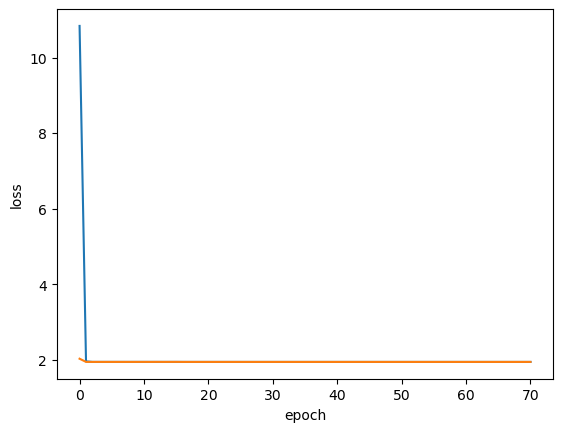

In [9]:
import matplotlib.pyplot as plt
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.xlabel("epoch")
plt.ylabel("loss")

plt.show()